In [1]:
import folium

print(folium.__file__)
print(folium.__version__)

/home/filipe/.virtualenvs/iris/lib/python2.7/site-packages/folium/__init__.py
0.1.6


In [2]:
import json
from IPython.display import HTML


def inline_map(m, width=750, height=500):
    """Takes a Folium map instance and return an iframe."""
    m._build_map()
    srcdoc = m.HTML

    # FIXME: Needs the same for plug-in data.
    if m.json_data:
        callback = 'function(callback){{callback(null, JSON.parse({}))}}'
        for path, data in m.json_data.items():
            json_data = json.dumps(data).replace('"', '&quot;')
            srcdoc = srcdoc.replace('d3.json, {}'.format(repr(path)),
                                    callback.format((repr(json_data))))

    srcdoc = srcdoc.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{srcdoc}" '
                 'style="width: 100%; height: {height}px; '
                 'border: none"></iframe>'.format(srcdoc=srcdoc,
                                                  height=height))
    return embed


In [3]:
import numpy as np


def sample_data(shape=(73, 145)):
    nlats, nlons = shape
    lats = np.linspace(-np.pi / 2, np.pi / 2, nlats)
    lons = np.linspace(0, 2 * np.pi, nlons)
    lons, lats = np.meshgrid(lons, lats)
    wave = 0.75 * (np.sin(2 * lats) ** 8) * np.cos(4 * lons)
    mean = 0.5 * np.cos(2 * lats) * ((np.sin(2 * lats)) ** 2 + 2)

    lats = np.rad2deg(lats)
    lons = np.rad2deg(lons)
    data = wave + mean

    return lons, lats, data


lon, lat, data = sample_data(shape=(73, 145))
lon -= 180

In [4]:
%matplotlib inline

import matplotlib

cm = matplotlib.cm.get_cmap('cubehelix')

normed_data = (data - data.min()) / (data.max() - data.min())
colored_data = cm(normed_data)

# Bad

In [5]:
mapa = folium.Map(location=[lat.mean(), lon.mean()], zoom_start=1)

mapa.image_overlay(colored_data, min_lat=lat.min(), max_lat=lat.max(),
                   min_lon=lon.min(), max_lon=lon.max(), image_opacity=0.25)

mapa

# Good

In [6]:
from folium.utilities import geodetic_to_mercator


mapa = folium.Map(location=[lat.mean(), lon.mean()], zoom_start=1)

mapa.image_overlay(geodetic_to_mercator(colored_data), min_lat=lat.min(), max_lat=lat.max(),
                   min_lon=lon.min(), max_lon=lon.max(), image_opacity=0.25)

mapa

# Same as above but with cartopy


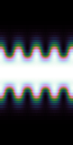

In [7]:
import cartopy.crs as ccrs
from cartopy.img_transform import warp_array

source_extent = [lon.min(), lon.max(), lat.min(), lat.max()]

new_data = warp_array(colored_data,
                      target_proj=ccrs.GOOGLE_MERCATOR,
                      source_proj=ccrs.PlateCarree(),
                      target_res=data.shape,
                      source_extent=source_extent,
                      target_extent=None,
                      mask_extrapolated=False)


mapa = folium.Map(location=[lat.mean(), lon.mean()], zoom_start=1)
mapa.image_overlay(new_data[0],
                   min_lat=lat.min(), max_lat=lat.max(),
                   min_lon=lon.min(), max_lon=lon.max(),
                   image_opacity=0.25)

inline_map(mapa)

TODO: Try [rasterio](https://github.com/mapbox/rasterio/blob/ca75cf0a842943c1b3da4522e6ea3500215130fd/docs/reproject.rst).  Rasterio can warp images and arrays.

# Compare to original

In [8]:
from IPython.display import IFrame

IFrame("http://scitools.org.uk/cartopy/docs/latest/examples/waves.html", width=900, height=750)